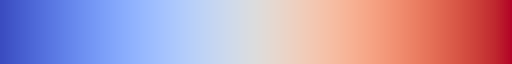

In [521]:
import os
import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings(action="ignore", category=FutureWarning)

import numpy as np
import pandas as pd
from scipy.stats import stats, mstats
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import ticker
import seaborn as sns
import builtins
from imblearn.over_sampling import SMOTE


from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

sns.color_palette("coolwarm", as_cmap=True)

In [522]:
data_path = os.path.join('..', 'data', 'DCCC.csv')
data = pd.read_csv(data_path, header=1)
data.rename(columns={'default payment next month': 'DEFAULT'}, inplace=True)
data.rename(columns={'PAY_2': 'PAY_1'}, inplace=True)
data.rename(columns={'PAY_3': 'PAY_2'}, inplace=True)
data.rename(columns={'PAY_4': 'PAY_3'}, inplace=True)
data.rename(columns={'PAY_5': 'PAY_4'}, inplace=True)
data.rename(columns={'PAY_6': 'PAY_5'}, inplace=True)
data.drop('ID', axis=1, inplace=True)
data.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_1,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEFAULT
0,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
1,120000,2,2,2,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,50000,2,2,1,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,50000,1,2,1,57,-1,0,-1,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


## Data Exploration and Cleaning


In [523]:
print(data.shape)
print(data.info())
print(data.isnull().sum())

(30000, 24)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 24 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   LIMIT_BAL  30000 non-null  int64
 1   SEX        30000 non-null  int64
 2   EDUCATION  30000 non-null  int64
 3   MARRIAGE   30000 non-null  int64
 4   AGE        30000 non-null  int64
 5   PAY_0      30000 non-null  int64
 6   PAY_1      30000 non-null  int64
 7   PAY_2      30000 non-null  int64
 8   PAY_3      30000 non-null  int64
 9   PAY_4      30000 non-null  int64
 10  PAY_5      30000 non-null  int64
 11  BILL_AMT1  30000 non-null  int64
 12  BILL_AMT2  30000 non-null  int64
 13  BILL_AMT3  30000 non-null  int64
 14  BILL_AMT4  30000 non-null  int64
 15  BILL_AMT5  30000 non-null  int64
 16  BILL_AMT6  30000 non-null  int64
 17  PAY_AMT1   30000 non-null  int64
 18  PAY_AMT2   30000 non-null  int64
 19  PAY_AMT3   30000 non-null  int64
 20  PAY_AMT4   30000 non-null  int64
 21  

In [524]:
for col in data.columns:
    num_missing = data[col].isnull().sum()
    num_unique = data[col].nunique()
    num_total = data.shape[0]
    print(f'{col} has {num_unique} unique values and {(num_missing/num_total)*100:.2f}% of the data is missing.')

LIMIT_BAL has 81 unique values and 0.00% of the data is missing.
SEX has 2 unique values and 0.00% of the data is missing.
EDUCATION has 7 unique values and 0.00% of the data is missing.
MARRIAGE has 4 unique values and 0.00% of the data is missing.
AGE has 56 unique values and 0.00% of the data is missing.
PAY_0 has 11 unique values and 0.00% of the data is missing.
PAY_1 has 11 unique values and 0.00% of the data is missing.
PAY_2 has 11 unique values and 0.00% of the data is missing.
PAY_3 has 11 unique values and 0.00% of the data is missing.
PAY_4 has 10 unique values and 0.00% of the data is missing.
PAY_5 has 10 unique values and 0.00% of the data is missing.
BILL_AMT1 has 22723 unique values and 0.00% of the data is missing.
BILL_AMT2 has 22346 unique values and 0.00% of the data is missing.
BILL_AMT3 has 22026 unique values and 0.00% of the data is missing.
BILL_AMT4 has 21548 unique values and 0.00% of the data is missing.
BILL_AMT5 has 21010 unique values and 0.00% of the da

In [525]:
categorical_columns = ['SEX','EDUCATION', 'MARRIAGE']
categorical_columns += [f'PAY_{i}' for i in range(0,6)]
for col in categorical_columns:
    print(f'Unique Values in {col}:', sorted(data[col].unique()))

Unique Values in SEX: [np.int64(1), np.int64(2)]
Unique Values in EDUCATION: [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6)]
Unique Values in MARRIAGE: [np.int64(0), np.int64(1), np.int64(2), np.int64(3)]
Unique Values in PAY_0: [np.int64(-2), np.int64(-1), np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8)]
Unique Values in PAY_1: [np.int64(-2), np.int64(-1), np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8)]
Unique Values in PAY_2: [np.int64(-2), np.int64(-1), np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8)]
Unique Values in PAY_3: [np.int64(-2), np.int64(-1), np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8)]
Unique Values in PAY_4: [np.int64(-2), np.int64(-1), np.int64(0), np.in

In [526]:
data['EDUCATION'].replace({0:4, 5:4, 6:4}, inplace=True)
data['MARRIAGE'].replace({0:3}, inplace=True)

pay_columns = [f'PAY_{i}' for i in range(0, 6)]
for col in pay_columns:
    data[col].replace({-2:-1, -1:0, 0:1, 1:2, 2:3, 3:4, 4:5, 5:6, 6:7, 7:8, 8:9}, inplace=True)
for col in categorical_columns:
    print(f"Unique Values in '{col}' updated to:", sorted(data[col].unique()))

Unique Values in 'SEX' updated to: [np.int64(1), np.int64(2)]
Unique Values in 'EDUCATION' updated to: [np.int64(1), np.int64(2), np.int64(3), np.int64(4)]
Unique Values in 'MARRIAGE' updated to: [np.int64(1), np.int64(2), np.int64(3)]
Unique Values in 'PAY_0' updated to: [np.int64(-1), np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9)]
Unique Values in 'PAY_1' updated to: [np.int64(-1), np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9)]
Unique Values in 'PAY_2' updated to: [np.int64(-1), np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9)]
Unique Values in 'PAY_3' updated to: [np.int64(-1), np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9)]
Unique Values in 'PAY_4' updated to:

In [527]:
for col in categorical_columns:
    data[col] = data[col].astype('category')

## Feature Engineering


In [528]:
data['AVERAGE_BILL_AMT'] = data[[f'BILL_AMT{i}' for i in range(1, 7)]].mean(axis=1)

In [529]:
data['AVERAGE_PAY_AMT'] = data[[f'PAY_AMT{i}' for i in range(1, 7)]].mean(axis=1)

In [530]:
data['UTILIZATION_RATIO'] = data['AVERAGE_BILL_AMT'] / data['LIMIT_BAL']

## Outlier Analysis and Treatment


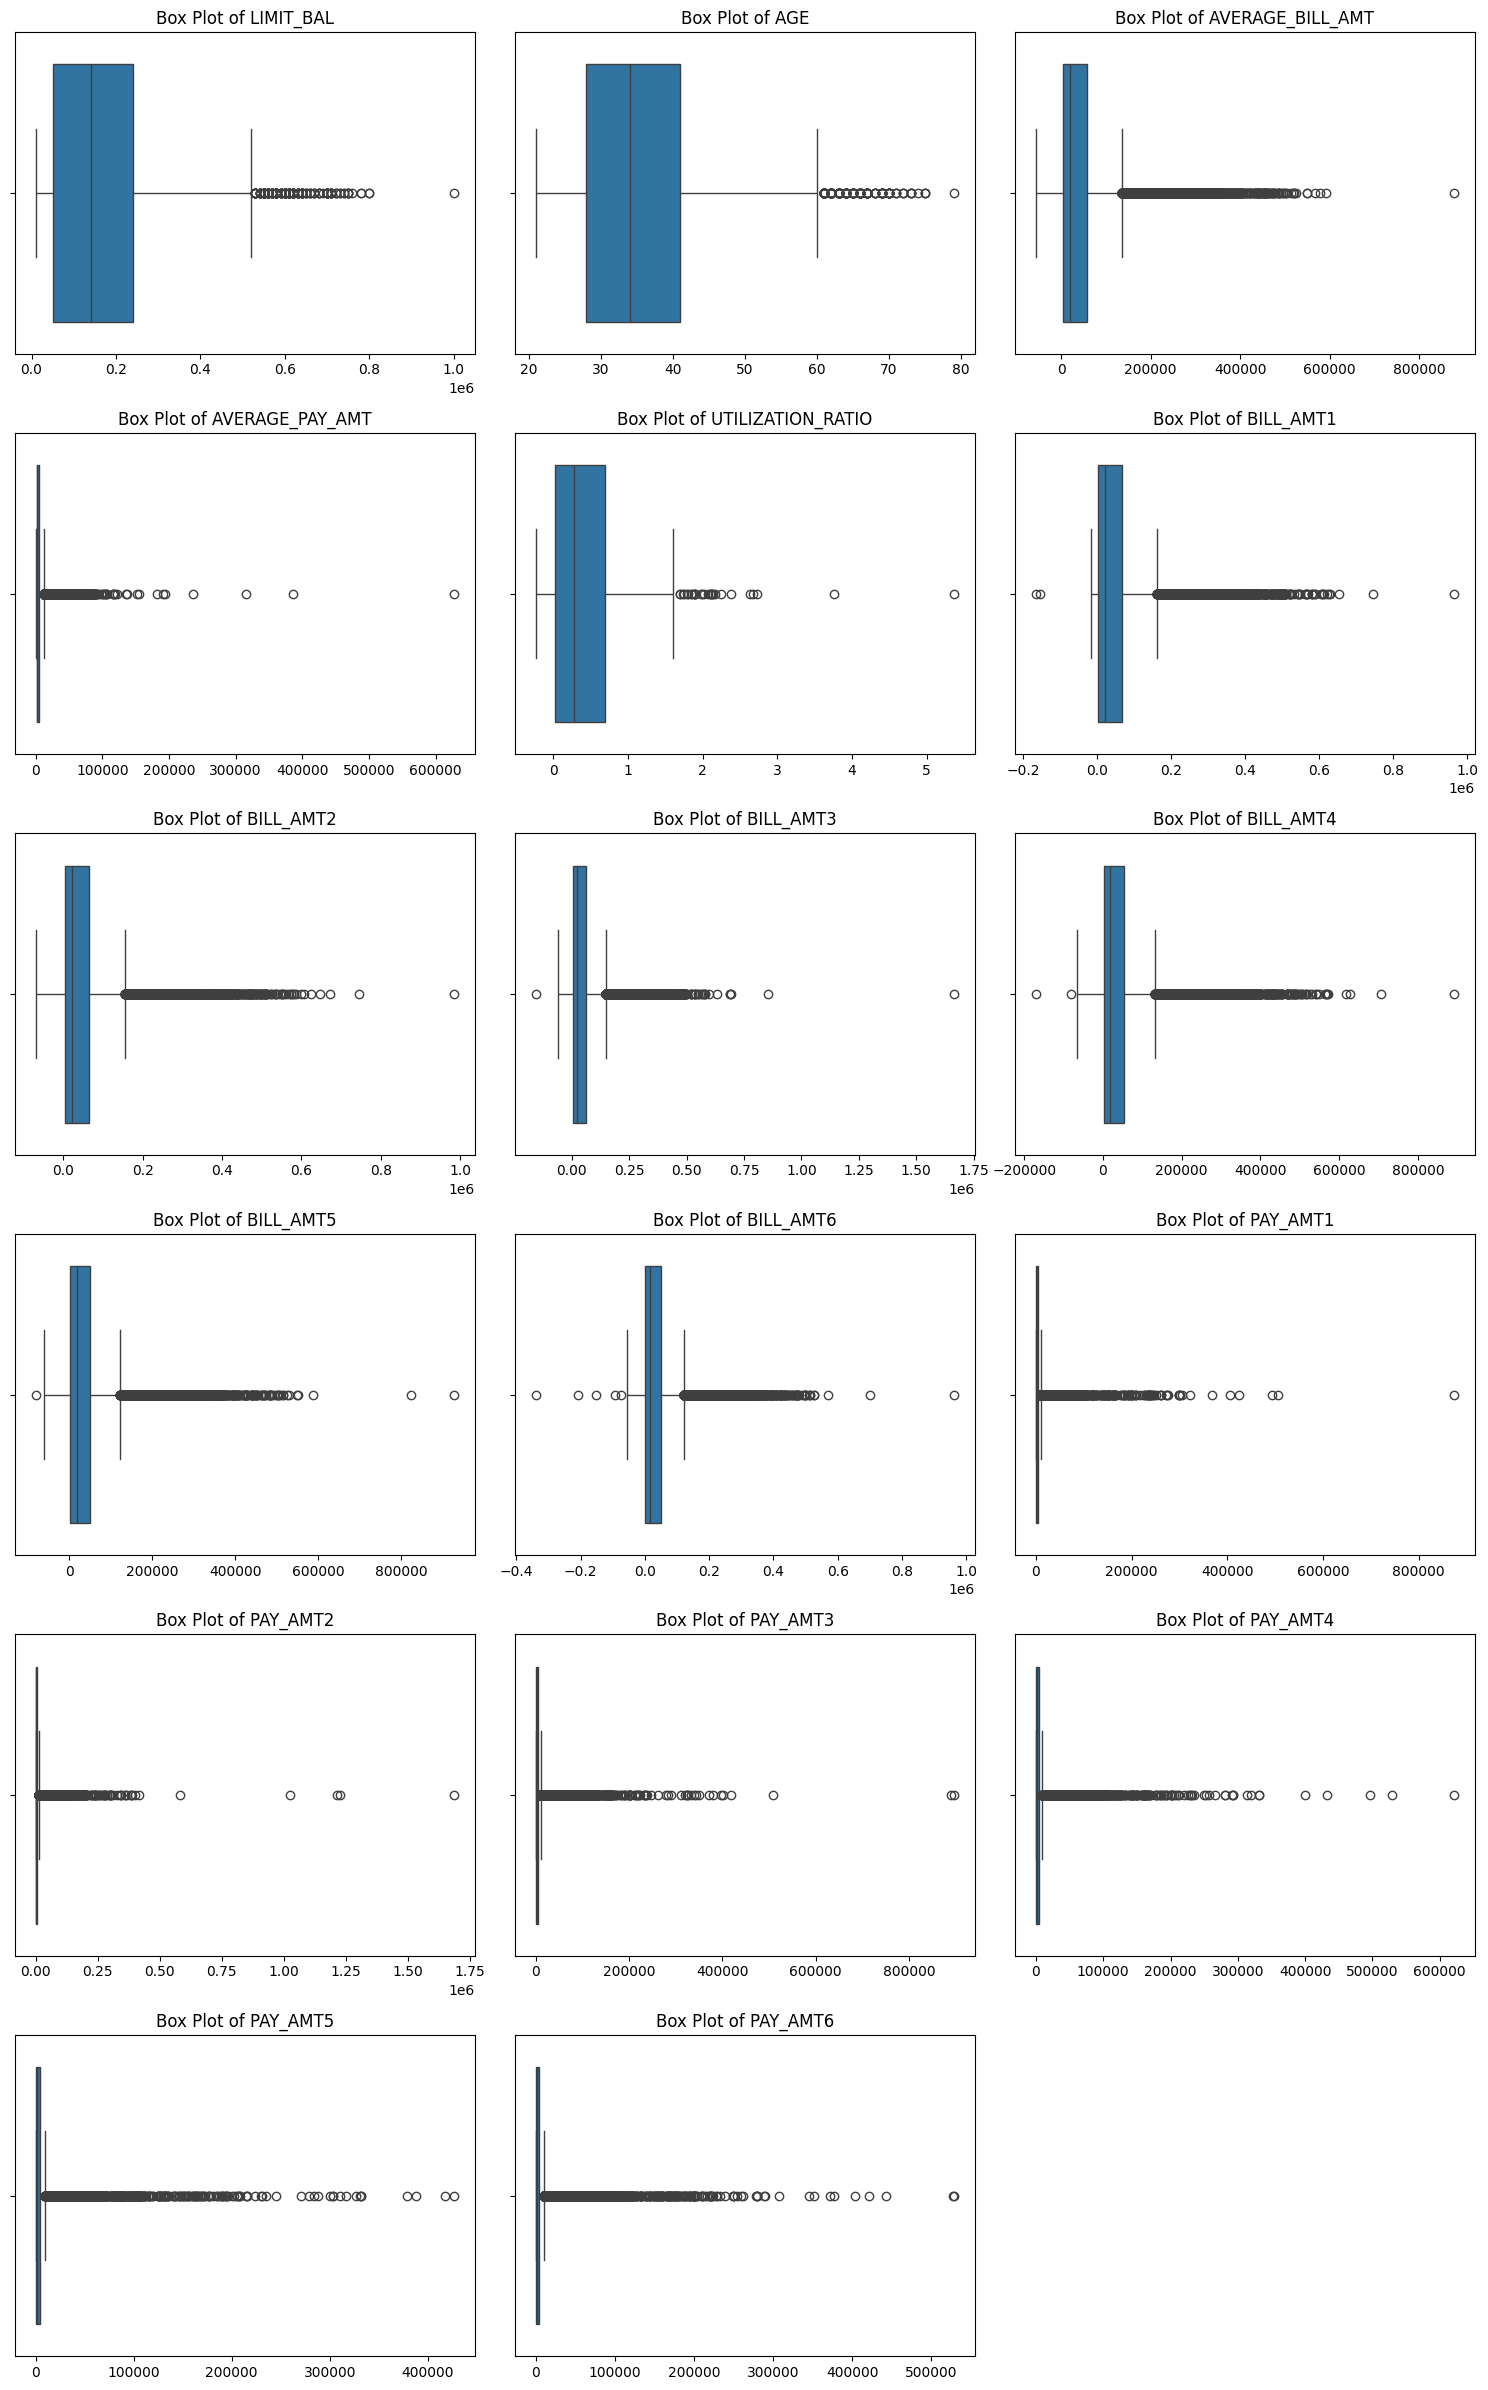

In [531]:
numerical_features = ['LIMIT_BAL', 'AGE', 'AVERAGE_BILL_AMT', 'AVERAGE_PAY_AMT', 'UTILIZATION_RATIO'] + [f'BILL_AMT{i}' for i in range (1, 7)] + [f'PAY_AMT{i}' for i in range (1, 7)]

num_plots = len(numerical_features)
num_cols = 3
num_rows = (num_plots + num_cols -1) // num_cols
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(15, num_rows *4))
axes = axes.flatten()

for i, feature in enumerate(numerical_features):
    sns.boxplot(x=data[feature], ax=axes[i])
    axes[i].set_title(f'Box Plot of {feature}')
    axes[i].set_xlabel('')

for i in range(len(numerical_features), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

### Skewness Factor


In [532]:
skewness = data[numerical_features].skew().sort_values(ascending=False)
print("\nSkewness of numerical features:")
print(skewness)
highly_skewed_features = skewness[skewness > 1].index.tolist()
print("\nHighly skewed features:")
print(highly_skewed_features)


Skewness of numerical features:
PAY_AMT2             30.453817
PAY_AMT3             17.216635
PAY_AMT1             14.668364
AVERAGE_PAY_AMT      14.616877
PAY_AMT4             12.904985
PAY_AMT5             11.127417
PAY_AMT6             10.640727
BILL_AMT3             3.087830
BILL_AMT5             2.876380
BILL_AMT6             2.846645
BILL_AMT4             2.821965
AVERAGE_BILL_AMT      2.734744
BILL_AMT2             2.705221
BILL_AMT1             2.663861
LIMIT_BAL             0.992867
AGE                   0.732246
UTILIZATION_RATIO     0.665967
dtype: float64

Highly skewed features:
['PAY_AMT2', 'PAY_AMT3', 'PAY_AMT1', 'AVERAGE_PAY_AMT', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'BILL_AMT3', 'BILL_AMT5', 'BILL_AMT6', 'BILL_AMT4', 'AVERAGE_BILL_AMT', 'BILL_AMT2', 'BILL_AMT1']


### Z-Score Outlier Scoring


In [ ]:
z_scores = np.abs(stats.zscore(data[numerical_features]))
z_threshold = 3
outliers_z = (z_scores > z_threshold).sum(axis=0)
print("\nNumber of outliers detected using Z-score method")
print(outliers_z)


Number of outliers detected using Z-score method
LIMIT_BAL            130
AGE                  141
AVERAGE_BILL_AMT     660
AVERAGE_PAY_AMT      509
UTILIZATION_RATIO     45
BILL_AMT1            686
BILL_AMT2            670
BILL_AMT3            661
BILL_AMT4            680
BILL_AMT5            651
BILL_AMT6            651
PAY_AMT1             390
PAY_AMT2             307
PAY_AMT3             362
PAY_AMT4             396
PAY_AMT5             414
PAY_AMT6             439
dtype: int64


### Interquantile Range Outlier Detection


In [534]:
Q1 = data[numerical_features].quantile(0.25)
Q3 = data[numerical_features].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
outliers_iqr = ((data[numerical_features] < lower_bound) | (data[numerical_features] > upper_bound)).sum()
print("\nNumber of outliers detected using IQR Method:")
print(outliers_iqr)


Number of outliers detected using IQR Method:
LIMIT_BAL             167
AGE                   272
AVERAGE_BILL_AMT     2575
AVERAGE_PAY_AMT      2898
UTILIZATION_RATIO      29
BILL_AMT1            2400
BILL_AMT2            2395
BILL_AMT3            2469
BILL_AMT4            2622
BILL_AMT5            2725
BILL_AMT6            2693
PAY_AMT1             2745
PAY_AMT2             2714
PAY_AMT3             2598
PAY_AMT4             2994
PAY_AMT5             2945
PAY_AMT6             2958
dtype: int64


### Log Transformation


In [536]:
z_scores = np.abs(stats.zscore(data[numerical_features]))

# Define a threshold for z-score
z_threshold = 3

# Identify outliers: rows where any z-score > threshold
outliers = (z_scores > z_threshold).any(axis=1)

# Summary of outliers
num_outliers = outliers.sum()
print(f"\nNumber of outliers detected: {num_outliers}")

print(f"\nNumber of records before outlier removal: {data.shape[0]}")
df_cleaned = data[~outliers].reset_index(drop=True)
print(f"Number of records after outlier removal: {df_cleaned.shape[0]}")

# 6. Evaluating the Impact of Outlier Removal
print("\nSummary Statistics Before Outlier Removal:")
print(data[numerical_features].describe())

print("\nSummary Statistics After Outlier Removal:")
print(df_cleaned[numerical_features].describe())


Number of outliers detected: 2961

Number of records before outlier removal: 30000
Number of records after outlier removal: 27039

Summary Statistics Before Outlier Removal:
            LIMIT_BAL           AGE  AVERAGE_BILL_AMT  AVERAGE_PAY_AMT  \
count    30000.000000  30000.000000      30000.000000     30000.000000   
mean    167484.322667     35.485500      44976.945200      5275.232094   
std     129747.661567      9.217904      63260.721860     10137.946323   
min      10000.000000     21.000000     -56043.166667         0.000000   
25%      50000.000000     28.000000       4781.333333      1113.291667   
50%     140000.000000     34.000000      21051.833333      2397.166667   
75%     240000.000000     41.000000      57104.416667      5583.916667   
max    1000000.000000     79.000000     877313.833333    627344.333333   

       UTILIZATION_RATIO      BILL_AMT1      BILL_AMT2     BILL_AMT3  \
count       30000.000000   30000.000000   30000.000000  3.000000e+04   
mean          

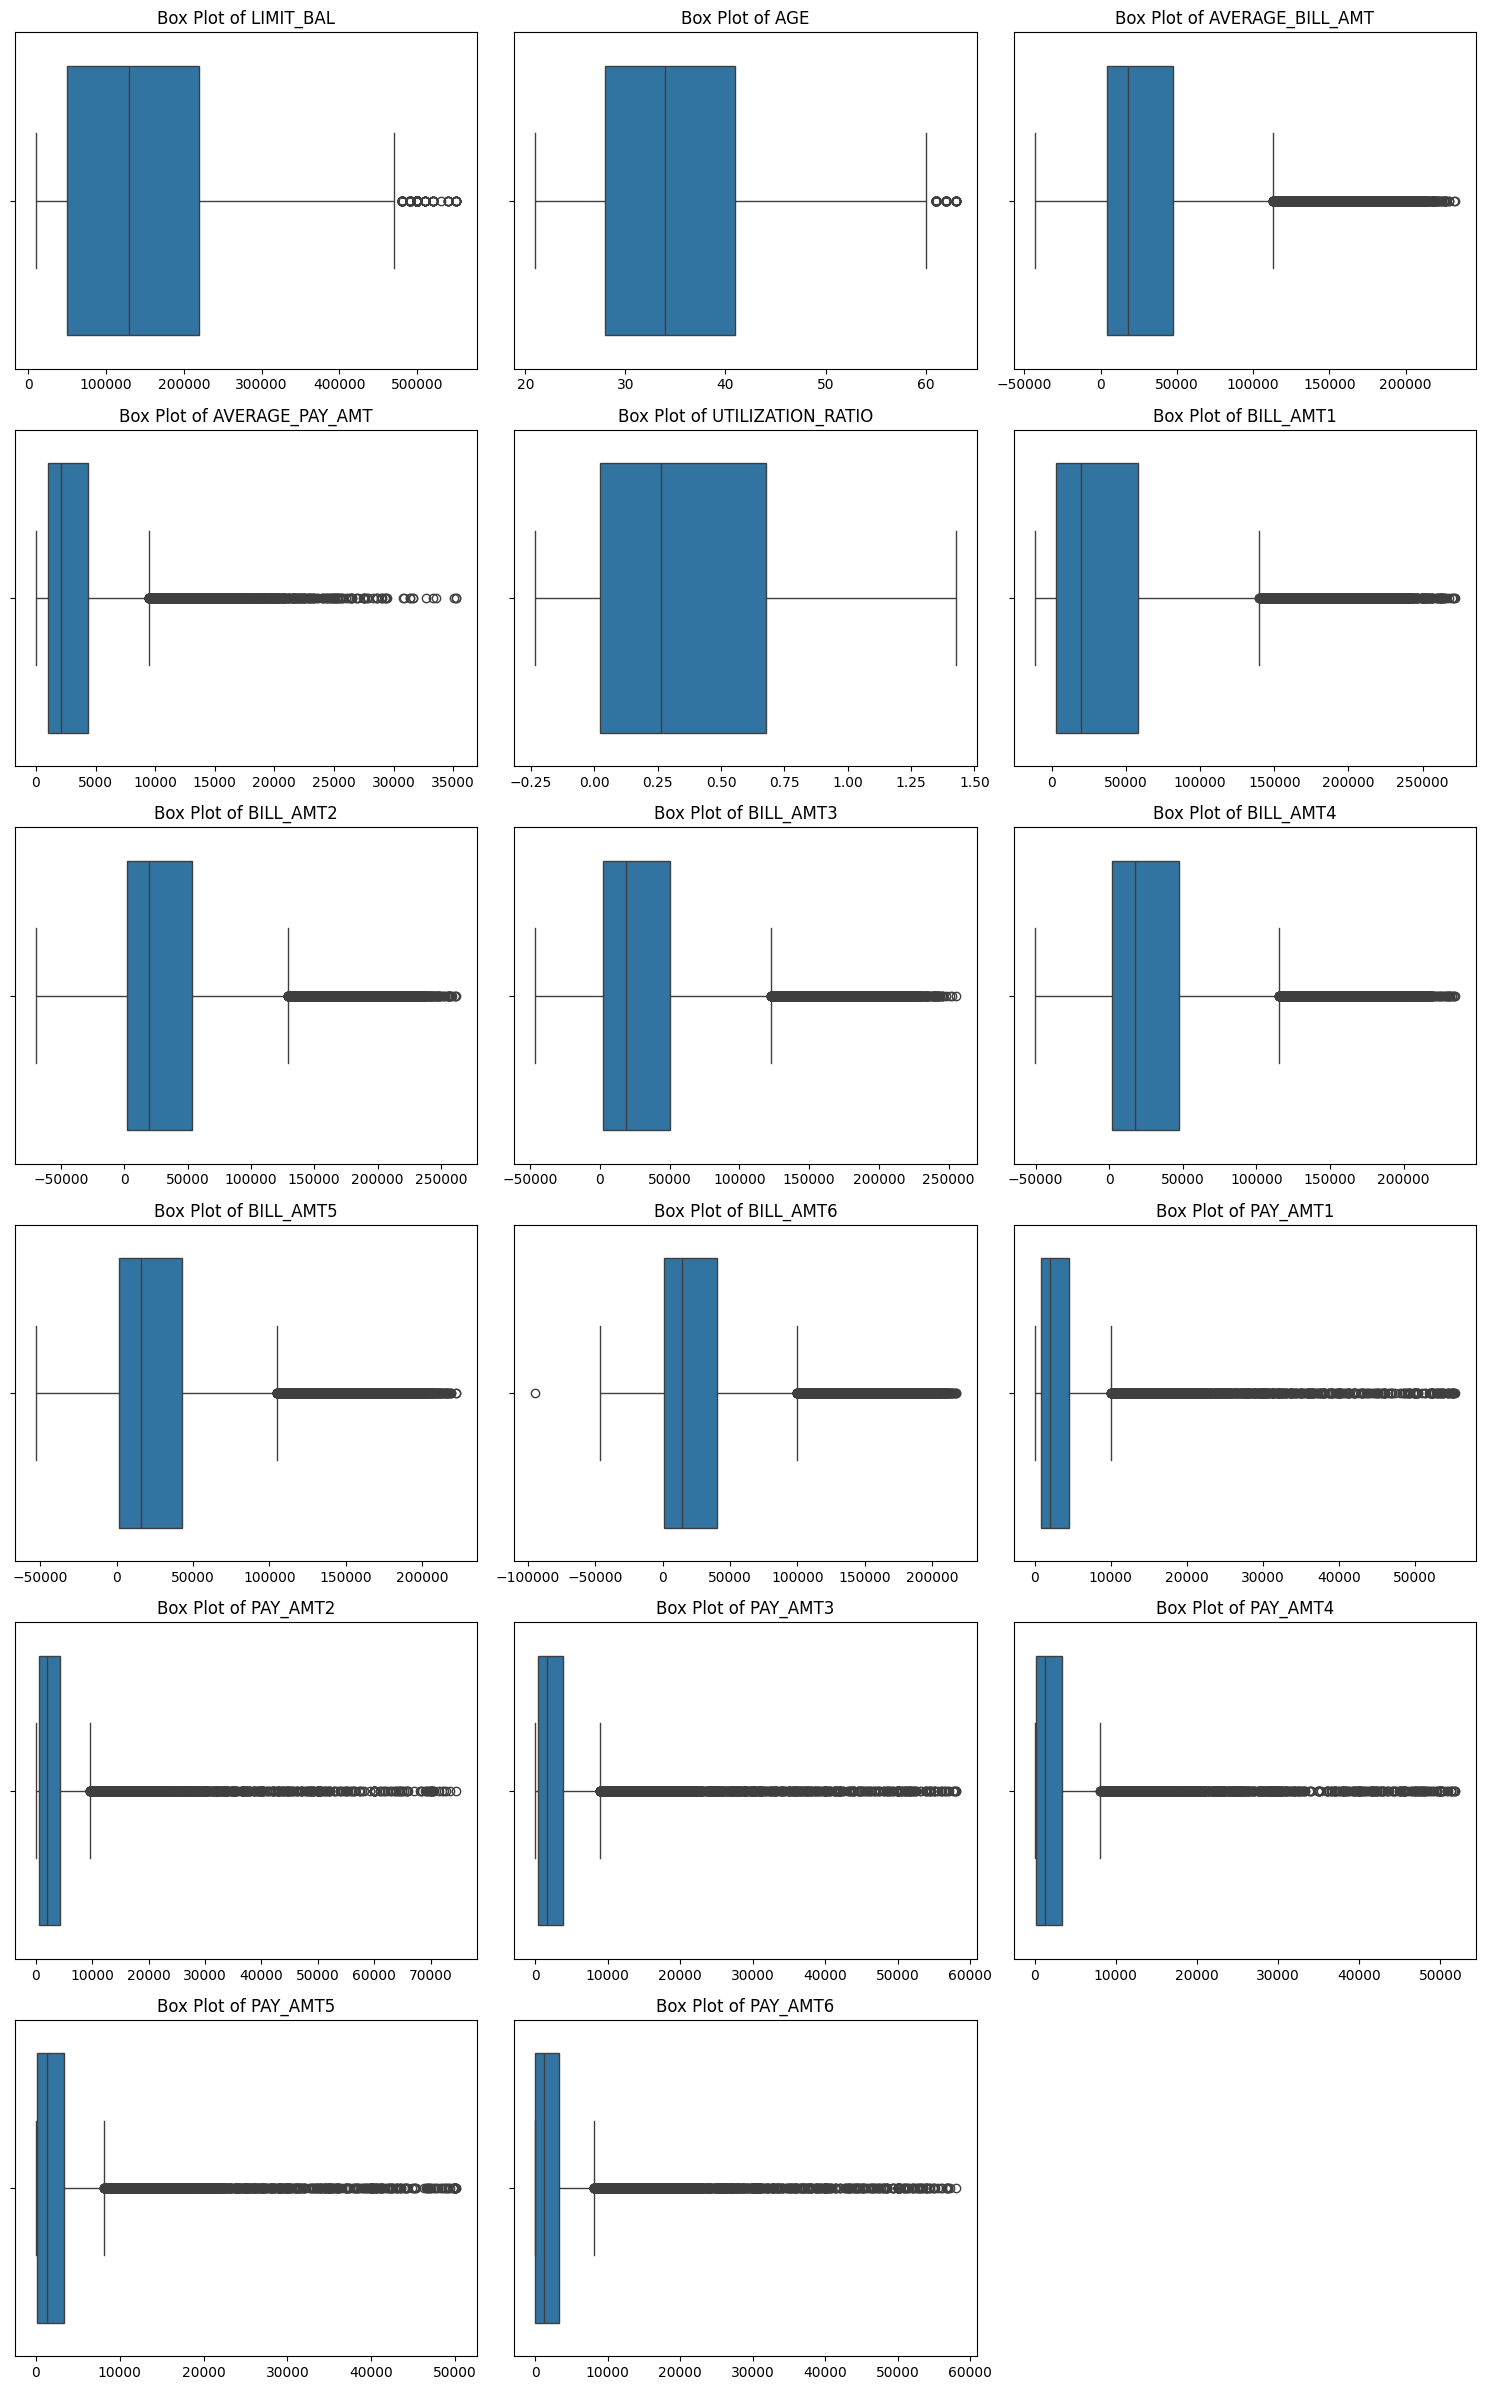

In [539]:
num_plots = len(numerical_features)
num_cols = 3
num_rows = (num_plots + num_cols -1) // num_cols
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(15, num_rows *4))
axes = axes.flatten()

for i, feature in enumerate(numerical_features):
    sns.boxplot(x=df_cleaned[feature], ax=axes[i])
    axes[i].set_title(f'Box Plot of {feature}')
    axes[i].set_xlabel('')

for i in range(len(numerical_features), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

## Exploratory Analysis


### Covariate Analysis


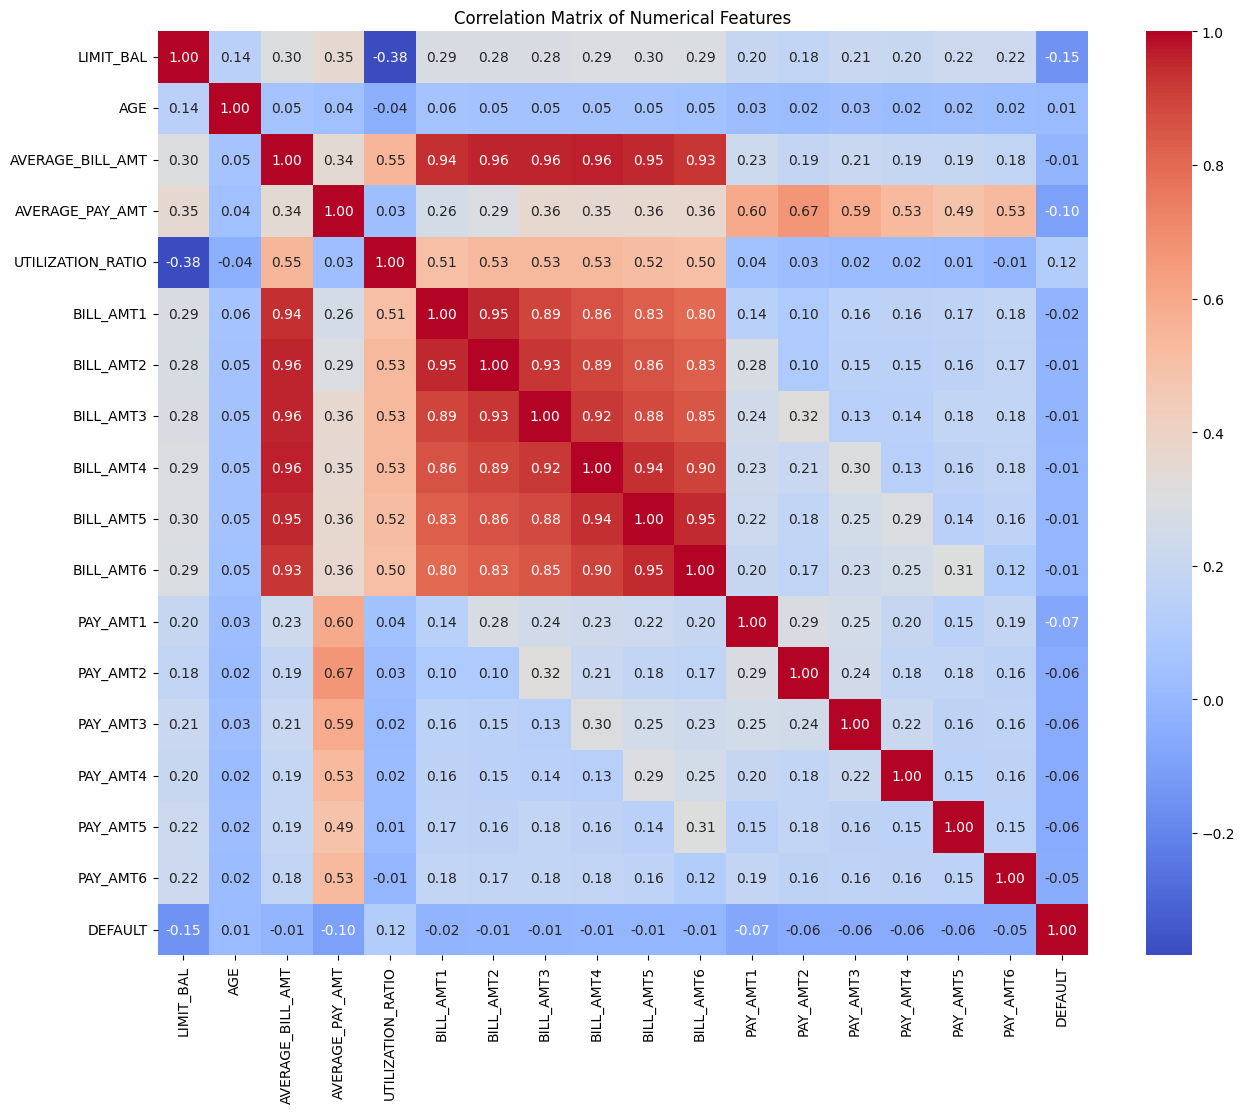

In [540]:
corr_matrix = data[numerical_features + ['DEFAULT']].corr()
plt.figure(figsize=(15, 12))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix of Numerical Features')
plt.show()

### Bivariate Analysis


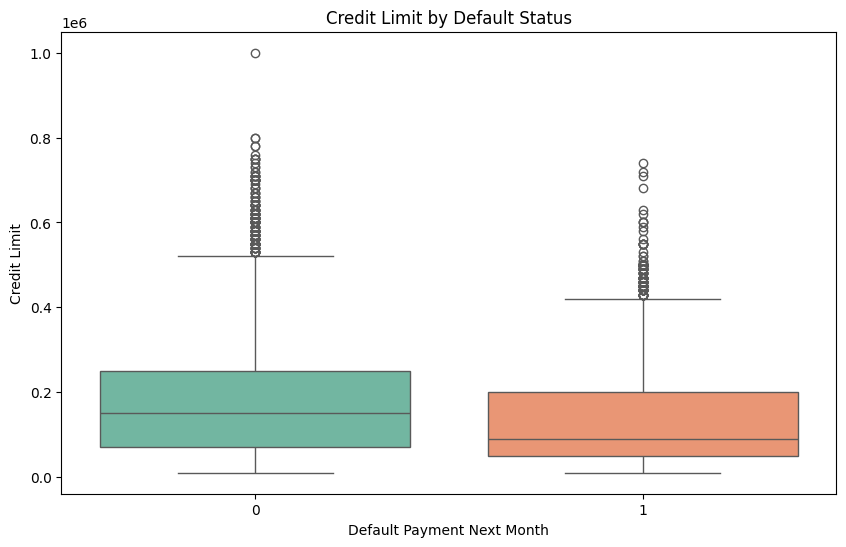

In [541]:
plt.figure(figsize=(10,6))
sns.boxplot(x='DEFAULT', y='LIMIT_BAL', data=data, palette='Set2')
plt.title('Credit Limit by Default Status')
plt.xlabel('Default Payment Next Month')
plt.ylabel('Credit Limit')
plt.show()

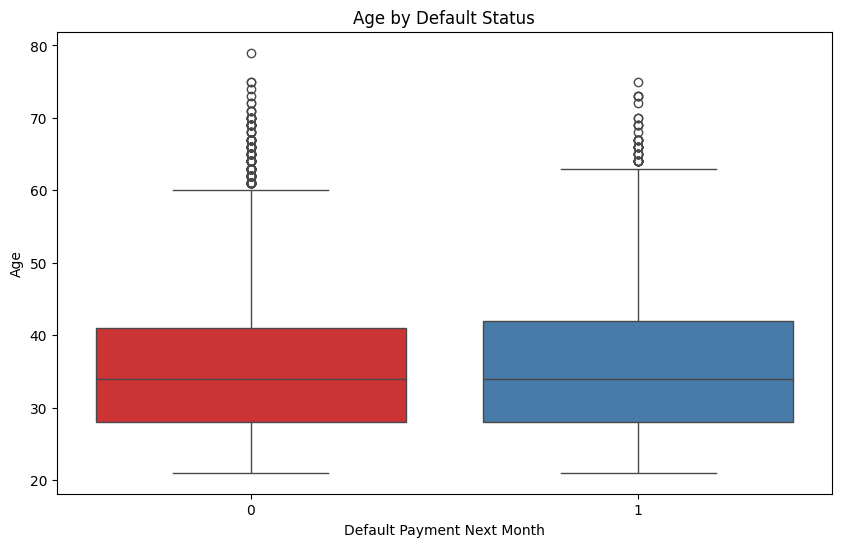

In [542]:
plt.figure(figsize=(10,6))
sns.boxplot(x='DEFAULT', y='AGE', data=data, palette='Set1')
plt.title('Age by Default Status')
plt.xlabel('Default Payment Next Month')
plt.ylabel('Age')
plt.show()

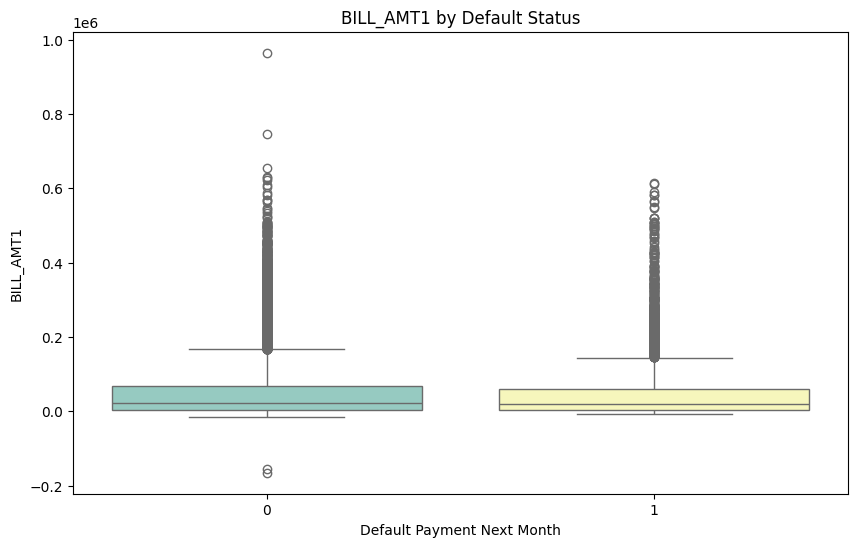

In [543]:
plt.figure(figsize=(10,6))
sns.boxplot(x='DEFAULT', y='BILL_AMT1', data=data, palette='Set3')
plt.title('BILL_AMT1 by Default Status')
plt.xlabel('Default Payment Next Month')
plt.ylabel('BILL_AMT1')
plt.show()

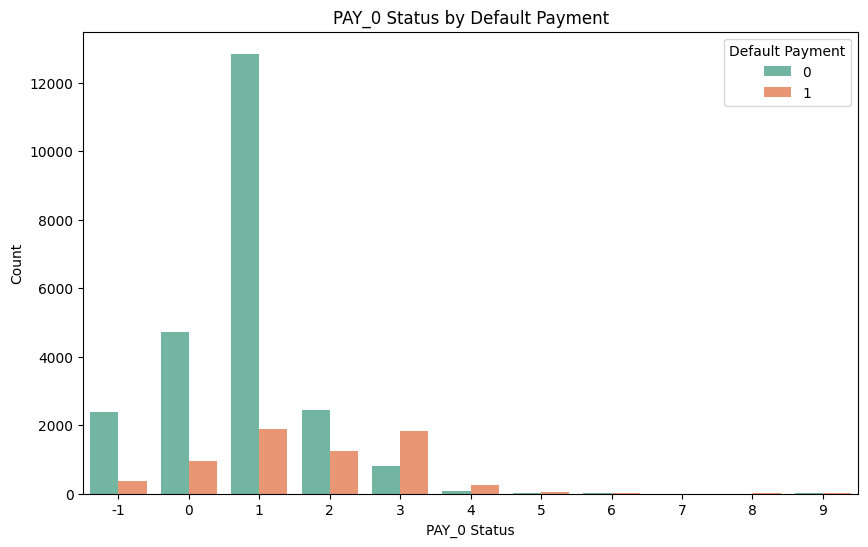

In [544]:
plt.figure(figsize=(10,6))
sns.countplot(x='PAY_0', hue='DEFAULT', data=data, palette='Set2')
plt.title('PAY_0 Status by Default Payment')
plt.xlabel('PAY_0 Status')
plt.ylabel('Count')
plt.legend(title='Default Payment')
plt.show()

## Bivariate Analysis


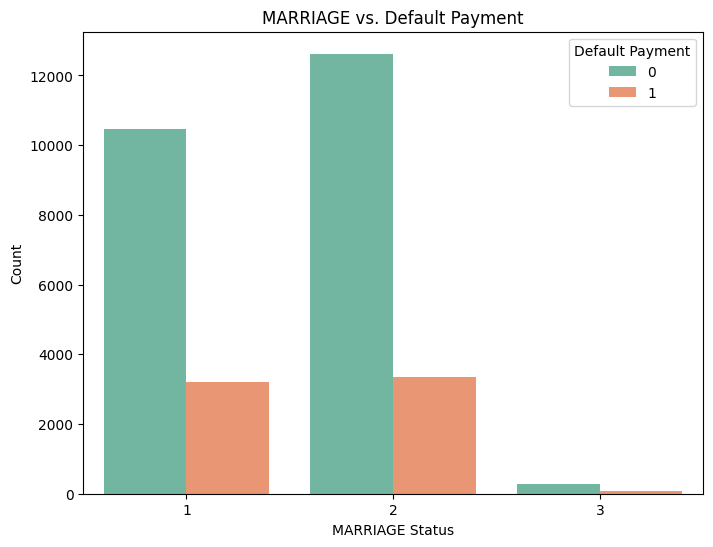

In [545]:
plt.figure(figsize=(8,6))
sns.countplot(x='MARRIAGE', hue='DEFAULT', data=data, palette='Set2')
plt.title('MARRIAGE vs. Default Payment')
plt.xlabel('MARRIAGE Status')
plt.ylabel('Count')
plt.legend(title='Default Payment')
plt.show()

## Data Preprocessing and Feature Scaling


In [546]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 27 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   LIMIT_BAL          30000 non-null  int64   
 1   SEX                30000 non-null  category
 2   EDUCATION          30000 non-null  category
 3   MARRIAGE           30000 non-null  category
 4   AGE                30000 non-null  int64   
 5   PAY_0              30000 non-null  category
 6   PAY_1              30000 non-null  category
 7   PAY_2              30000 non-null  category
 8   PAY_3              30000 non-null  category
 9   PAY_4              30000 non-null  category
 10  PAY_5              30000 non-null  category
 11  BILL_AMT1          30000 non-null  int64   
 12  BILL_AMT2          30000 non-null  int64   
 13  BILL_AMT3          30000 non-null  int64   
 14  BILL_AMT4          30000 non-null  int64   
 15  BILL_AMT5          30000 non-null  int64   
 16  BILL

In [ ]:
# Define features and target
X = df[features]
y = df[target]

# One-hot encode categorical features except PAY columns (already ordinal encoded)
categorical_to_encode = ['SEX', 'EDUCATION', 'MARRIAGE']
X = pd.get_dummies(X, columns=categorical_to_encode, drop_first=True)

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Identify numerical columns for scaling
numerical_cols = log_billing_features + original_numerical

# Initialize scaler
scaler = StandardScaler()

ValueError: Input X contains infinity or a value too large for dtype('float64').

In [520]:
X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])

NameError: name 'numerical_cols' is not defined

In [ ]:
log_reg = LogisticRegression(max_iter=1000, random_state=42)
log_reg.fit(X_train, y_train)


In [ ]:
y_pred = log_reg.predict(X_test)
y_proba = log_reg.predict_proba(X_test)[:,1]

In [ ]:
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

In [ ]:
auc = roc_auc_score(y_test, y_proba)
print(f"AUC-ROC Score: {auc:.4f}")

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'Logistic Regression (AUC = {auc:.4f})')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()